In [1]:
import sys
sys.path.append("..")
import d2lzh_pytorch.torch as d2l

import torch
from torch import nn

from d2lzh_pytorch import myUtils

# 加载数据
from d2lzh_pytorch.nlp.load_data.load_snli import load_data_snli

# 加载模型
from d2lzh_pytorch.nlp.model.app_DecomposableAttention import get_DecomposableAttention


# 加载训练 train_ch13
from d2lzh_pytorch.nlp.train.train_ch13 import train_ch13


# 加载预测
from d2lzh_pytorch.nlp.predict.predict_snli import predict_snli


In [2]:
batch_size = 256
num_steps = 50

# 加载数据
# train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

train_iter, test_iter, vocab  = load_data_snli(batch_size, num_steps)

print(len(vocab))

read 549367 examples
read 9824 examples
18678


In [3]:

# 加载模型
net = get_DecomposableAttention()

In [12]:
# net

In [4]:

lr = 0.001
num_epochs = 5


trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

time consuming: 90.3899
loss 0.685, train acc 0.711, test acc 0.730
30388.7 examples/sec on [device(type='cuda', index=0)]


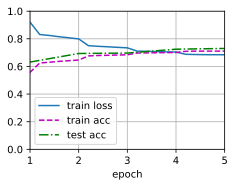

In [5]:
devices = myUtils.try_all_gpus()

# 训练
d2l.train_ch13(net, train_iter, test_iter, 
               loss, 
               trainer, 
               num_epochs,
               devices
              )

In [6]:
# 保存模型
net = net.to("cpu")

import datetime
str_time = str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
save_path = 'app_DecomposableAttention_net_%s.pt' % str_time
torch.save(net, save_path)  # 全保存 39M
print("训练完毕, 模型 %s 已保存至当前路径" % save_path)

训练完毕, 模型 app_DecomposableAttention_net_2023-06-29_10-11-02.pt 已保存至当前路径


# 使用模型预测数据

In [8]:

net = net.to('cuda')

# str_list_1 = ['he', 'is', 'good', 'man' ,'.']
# str_list_2 = ['he', 'is', 'bad', 'woman', '.']

str_list_1 = 'he is good man .'.split(' ')
str_list_2 = 'he say ok .'.split(' ')


# 使用
predict_snli(net, vocab,
             str_list_1, 
             str_list_2
            )

'entailment'

In [10]:
# 使用测试的数据集进行测试

# 加载数据
from d2lzh_pytorch.nlp.load_data.load_snli import read_snli


# data_dir = d2l.download_extract('SNLI')  # 857M
# train_data = d2l.read_snli(data_dir, is_train=False)
data_dir = "/mnt/g1t/ai_data/Datasets_on_HHD/d2l_data/data/snli_1.0"
train_data = read_snli(data_dir, is_train=False)

sum_total = 0
acc_sum = 0
for x0, x1, y in zip(train_data[0], 
                     train_data[1], 
                     train_data[2]):
    # print('前提：', x0)
    # print('假设：', x1)
    # print('标签：', y)
    res = predict_snli(net, vocab,
                      x0.split(' '), 
                      x1.split(' ')
                     )
    label = 'entailment' if y == 0 else 'contradiction' if y == 1 else 'neutral'
    if label == res:
        # 预测正确
        acc_sum += 1
        pass
    else:
        # 预测错误
        print('error: y: %s , y_hat: %s' %(label, res), '内容: %s \t %s' % (x0, x1))
        pass

    sum_total += 1
    if sum_total >= 200:
        break

print('acc: %.4f' % (acc_sum / sum_total))    

error: y: neutral , y_hat: entailment 内容: This church choir sings to the masses as they sing joyous songs from the book at a church . 	 The church has cracks in the ceiling .
error: y: entailment , y_hat: neutral 内容: A woman with a green headscarf , blue shirt and a very big grin . 	 The woman is very happy .
error: y: contradiction , y_hat: neutral 内容: A woman with a green headscarf , blue shirt and a very big grin . 	 The woman has been shot .
error: y: contradiction , y_hat: entailment 内容: An old man with a package poses in front of an advertisement . 	 A man walks by an ad .
error: y: contradiction , y_hat: neutral 内容: A statue at a museum that no seems to be looking at . 	 Tons of people are gathered around the statue .
error: y: entailment , y_hat: neutral 内容: A land rover is being driven across a river . 	 A Land Rover is splashing water as it crosses a river .
error: y: contradiction , y_hat: neutral 内容: A land rover is being driven across a river . 	 A sedan is stuck in the mi